# Custom analysis pipeline for deep mutational scanning data from phage display

This is a simple, easy-to-use and straightforward script to analyze next-generation sequencing (NGS) data obtained from phage display experiments which we used to investigate the interaction between the MLLE domain, a peptide-binding domain, and the PAM2 motif.
![sPAM2 paper graphical abstract.jpg](<attachment:sPAM2 paper graphical abstract.jpg>)  
**Graphical abstract from our paper: Deep Mutational Scanning of an Engineered High-affinity Ligand of the poly(A) Binding Protein MLLE Domain** (Behvarmanesh A et al., *Journal of Molecular Biology*, 2025)

---
## Components of the notebook
This Jupyter notebook consists of four parts:
1. Input fastq file(s) from the sequencing, (extract coding region) trim, translate sequences and filter sequences. Identify most abundant sequences and store them in a .txt file, calculate percentage (frequency) of each amino acid at every position.
2. Calculate log2-enrichment scores.
3. Plot your results as a heatmap.
4. Use logomaker to get a display your results as a sequence logo.

---
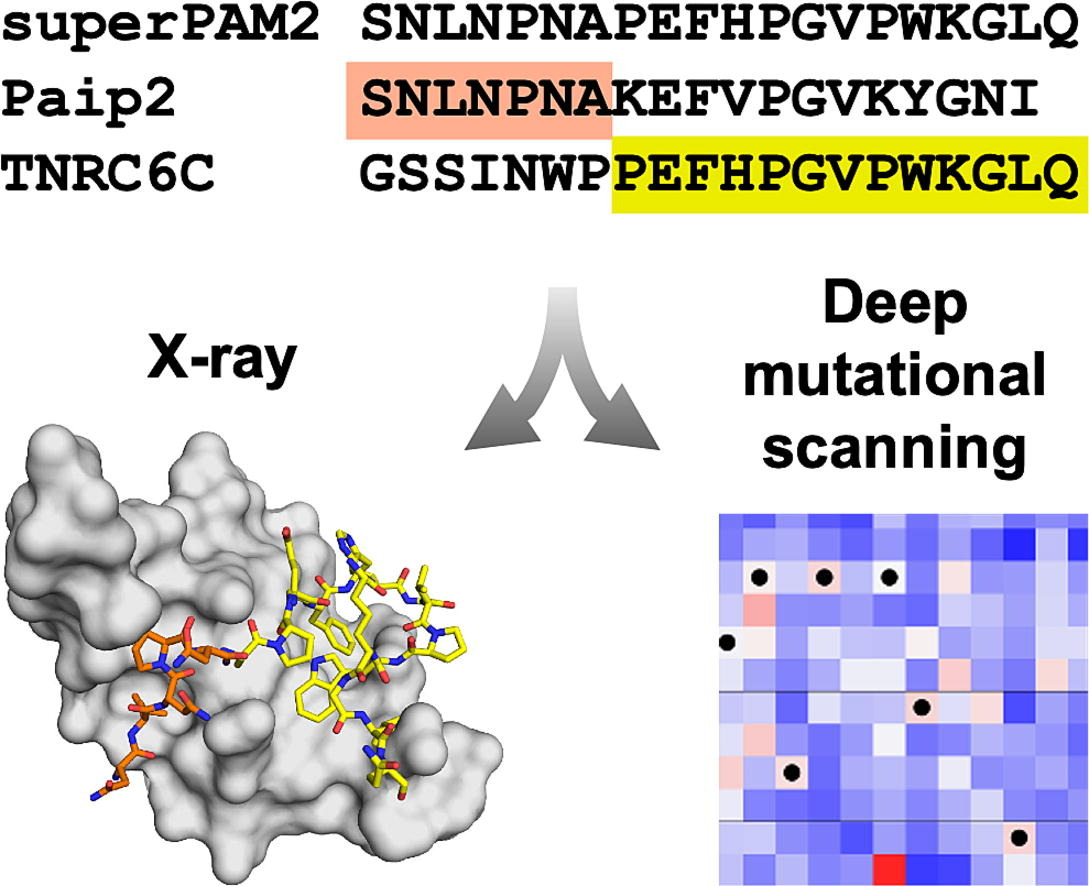

### 1. Sequence analysis and amino acid frequencies

In [ ]:
# Import all libraries and modules required for running this code
import os
from Bio import SeqIO
from Bio.Seq import Seq
from collections import Counter
import csv
import re
import pandas as pd
import numpy as np

# Define the specific pattern using regular expressions replacing your_pattern
specific_pattern = re.compile('your_pattern')  
# Path to the folder containing FASTQ file(s) to analyze
folder_path = r'your_folder_path'

# Iterate over each file in the folder with a .fastq extension
for file_name in os.listdir(folder_path):
    if file_name.endswith('.fastq'):
        file_path = os.path.join(folder_path, file_name)
        
        # Initialize a Counter for counting sequences for each file
        sequence_counts = Counter()

        # Read and translate sequences from the FASTQ file
        with open(file_path, 'r') as f:
            for record in SeqIO.parse(f, "fastq"):
                # Extract the coding region and trim sequences (adjust slice as necessary based on the length of your primers and sequence)
                coding_dna = record.seq[15:75]

                # Translate the coding region to a protein sequence, stopping at the first stop codon
                protein_sequence = coding_dna.translate(to_stop=True)

                # Filtering step (e.g. specific length and match to the defined pattern)
                if len(protein_sequence) == your_length and specific_pattern.fullmatch(str(protein_sequence)):
                    # Count the protein sequences
                    sequence_counts[str(protein_sequence)] += 1

        # Sort sequences by count
        top_sequences = sequence_counts.most_common(10)

        # Filenames for .txt and .csv outputs are based on the input filename
        txt_output_filename = f"mostabundantsequences_{file_name.split('.')[0]}.txt"
        csv_output_filename = f"aminoacid_percentages_{file_name.split('.')[0]}.csv"

        # Write the top sequences to a .txt file
        with open(txt_output_filename, 'w') as datafile:
            for seq, count in top_sequences:
                datafile.write(f"{seq}: {count}\n")

        # Counting amino acids at each position (from position 1 to X = length of your sequence + 1)
        position_counts = {i: Counter() for i in range(1, X)}

        # Iterate over sequences and count amino acids
        for seq, count in sequence_counts.items():
            for i, aa in enumerate(seq):
                position_counts[i + 1][aa] += count

        # Calculate total counts for each position
        total_counts = {i: sum(position_counts[i].values()) for i in range(1, X)}

        # Define amino acid order for output
        amino_acid_order = ['H', 'K', 'R', 'D', 'E', 'C', 'M', 'N', 'Q', 'S', 'T', 'A', 'I', 'L', 'V', 'F', 'W', 'Y', 'P', 'G']

        # Write amino acid counts and percentages to a .csv file
        with open(csv_output_filename, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(['Amino Acid'] + [f'Pos {i} %' for i in range(1, X)])

            for aa in amino_acid_order:
                row = [aa]
                row.extend((position_counts[i].get(aa, 0) / total_counts[i] * 100) if total_counts[i] > 0 else 0
                            for i in range(1, 21))
                writer.writerow(row)

### 2. Enrichment scores

In [ ]:
# Create dataframes with pandas
dataset1_df = pd.read_csv('aminoacid_percentages_DSP1449_UBR5_R3_S23_top_R1_merged.csv', index_col=0)  # Dataset after selection
dataset2_df = pd.read_csv('aminoacid_percentages_DSP1449_Input_library_S21_merged.csv', index_col=0)  # Library dataset

# Replace 0 values with NaN in dataset2_df before performing the division to avoid division by 0
dataset2_values = dataset2_df.values
dataset2_values = np.where(dataset2_values == 0, np.nan, dataset2_values)

# Calculate the log2 enrichment scores
log_enrichment_df = np.log2(dataset1_df.values / dataset2_values)

# Convert the result back into a DataFrame and write to a CSV file
new_columns = ['Pos. 1', 'Pos. 2', 'Pos. 3', 'Pos. 4', 'Pos. 5', 'Pos. 6', 'Pos. 7', 'Pos. 8', 'Pos. 9', 'Pos. 10', 'Pos. 11', 'Pos. 12', 'Pos. 13', 'Pos. 14', 'Pos. 15', 'Pos. 16', 'Pos. 17', 'Pos. 18', 'Pos. 19', 'Pos. 20']
log_enrichment_df = pd.DataFrame(log_enrichment_df, index=dataset1_df.index, columns=new_columns)

# Result is stored as a CSV file
log_enrichment_df.to_csv('log2scores_sPAM2_W16Q_U4.csv', index=True)

### 3. Heatmap plotting

In [ ]:
# Import all libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.patches import Circle
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from matplotlib import pyplot as plt

# Read CSV file (replace with the name of your file) with enrichment scores
enrichment_df = pd.read_csv('file_with_log2scores.csv', index_col=0)

# Define group labels and positions
group_labels = ['(+)', '(-)', 'Polar-neutral', 'Non-polar', 'Aromatic', 'Unique']
group_positions = [0, 3, 5, 11, 15, 18, 20]  # Define row indices for each group label

# Create figure and heatmap plot
fig, ax = plt.subplots(figsize=(24, 24)) # adjust figure size here

# Create custom colormap: blue - white - red
colors = ["blue", "whitesmoke", "red"]
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

# Set the normalization to center the colormap at 0
norm = TwoSlopeNorm(vmin=your_min, vcenter=0, vmax=your_max)

# Plot the heatmap
sns.heatmap(enrichment_df, cmap=cmap, norm=norm, vmin=your_min, vmax=your_max, cbar_kws={'ticks': [your_ticks]}, ax=ax, cbar=True)
ax.set_aspect('equal')

# # Formatting colorbar, labels and ticks
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=your_label_size, length=your_length, width=your_width)  # Adjust the number to change the font size, tick length and width
ax.set_ylabel('')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=your_fontsize)
plt.xticks(rotation=90, fontsize=your_fontsize)

# Add group labels as side text
for i, label in enumerate(group_labels):
    ax.text(-1, (group_positions[i] + group_positions[i + 1]) / 2, label,
            rotation=90, ha='center', va='center', fontsize=your_fontsize, color='black')

# Add horizontal lines to separate groups
for pos in group_positions[1:-1]:
    ax.axhline(pos, color='black', linewidth=1.5)

# Define positions where you want to add circles; write as: row, column pairs
positions = [(row, column)]  

# Add circles at the specified positions
for pos in positions:
    circle = Circle((pos[1] + 0.5, pos[0] + 0.5), 0.25, color='black', fill=True, lw=1)
    ax.add_patch(circle)

# Plot your data
plt.savefig('.tif', format='tiff', dpi=300, bbox_inches='tight')

### 4. Sequence logo: 
You can use the Python package described in this paper to generate sequence logos: Tareen A, Kinney JB. Logomaker: beautiful sequence logos in Python. *Bioinformatics*. 2020;36(7):2272-2274. doi:10.1093/bioinformatics/btz921  
Detailed instructions on installation along with examples and a tutorial can be found here: https://logomaker.readthedocs.io/ 
